In [35]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from astropy.table import Table

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

## Sample
Megan Bedell made an awesome cross-match available, which was online by the time I woke up on West Coast!

Let's match this to the McQuillan+2014 rotation catalog using Pandas & a join

In [6]:
Gfile = 'kepler_dr2_4arcsec.fits' # from http://gaia-kepler.fun, thanks to M. Bedell
data = Table.read(Gfile, format='fits')

In [18]:
gaia = data.to_pandas()
gaia.shape

(241989, 61)

In [17]:
rot_file = 'Table_Periodic.txt'
rot = pd.read_csv(rot_file)
rot.shape

(34030, 11)

In [23]:
df = pd.merge(rot, gaia, right_on='kepid', left_on='KID')
df.shape

(42301, 72)

In [24]:
df.columns

Index([u'KID', u'Teff', u'logg_x', u'Mass', u'Prot', u'Prot_err', u'Rper',
       u'LPH', u'w', u'DC', u'Flag', u'angDist', u'kepid', u'source_id',
       u'ra_gaia', u'ra_error', u'dec_gaia', u'dec_error', u'parallax',
       u'parallax_error', u'pmra', u'pmra_error', u'pmdec', u'pmdec_error',
       u'phot_g_mean_flux', u'phot_g_mean_flux_error', u'phot_g_mean_mag',
       u'phot_bp_mean_flux', u'phot_bp_mean_flux_error', u'phot_bp_mean_mag',
       u'phot_rp_mean_flux', u'phot_rp_mean_flux_error', u'phot_rp_mean_mag',
       u'bp_rp', u'radial_velocity', u'radial_velocity_error', u'teff_val',
       u'a_g_val', u'e_bp_min_rp_val', u'radius_val', u'lum_val',
       u'tm_designation', u'ra_kic', u'dec_kic', u'kepmag', u'teff',
       u'teff_err1', u'teff_err2', u'teff_prov', u'logg_y', u'logg_err1',
       u'logg_err2', u'logg_prov', u'feh', u'feh_err1', u'feh_err2',
       u'feh_prov', u'radius', u'radius_err1', u'radius_err2', u'mass',
       u'mass_err1', u'mass_err2', u'prov_sec',

## Quality Cuts
we need to trim the sample to get the best distances

(0, 1)

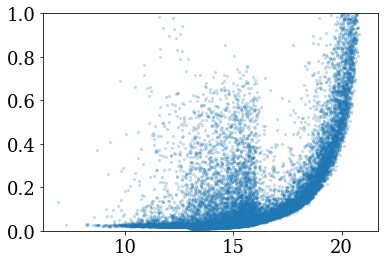

In [361]:
plt.scatter(df[ u'phot_g_mean_mag'],df[u'parallax_error'], s=5, alpha=.2)
plt.ylim(0,1)

In [362]:
ok = np.where(np.isfinite(df[u'parallax']) & # this is basically the same as the TGAS file...
              (df[u'parallax_error'] < 0.1) &
              np.isfinite(df[u'bp_rp']) & 
              (df[u'phot_bp_mean_flux_error']/df[u'phot_bp_mean_flux'] < 0.01) & 
              (df[u'phot_rp_mean_flux_error']/df[u'phot_rp_mean_flux'] < 0.01) & 
              (df[u'phot_g_mean_flux_error']/df[u'phot_g_mean_flux'] < 0.01))[0]

ok.shape


(30928,)

## The Gaia-Kepler Rotation CMD

In [363]:
# let's put an ischrone down 
isonames = ('Zini','Age','Mini','Mass','logL','logTe','logg','label','McoreTP',
            'C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo',
            'Cexcess','Z','mbolmag','Gmag','G_BPmag','G_RPmag','B_Tmag','V_Tmag',
            'Jmag','Hmag','Ksmag')

# output195874734622.dat # age = 1e8
# output783328222883.dat # age = 1e9
# output382961170123.dat # age = 5e9

iso_file = 'iso/output783328222883.dat'
iso = pd.read_table(iso_file, delim_whitespace=True, header=None, comment='#', names=isonames)

# get just the main sequence, and reverse it (for interpolating later)
iok = np.where((iso['label'] < 2) & (iso['Gmag'] > 1.7))[0][::-1]

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log10


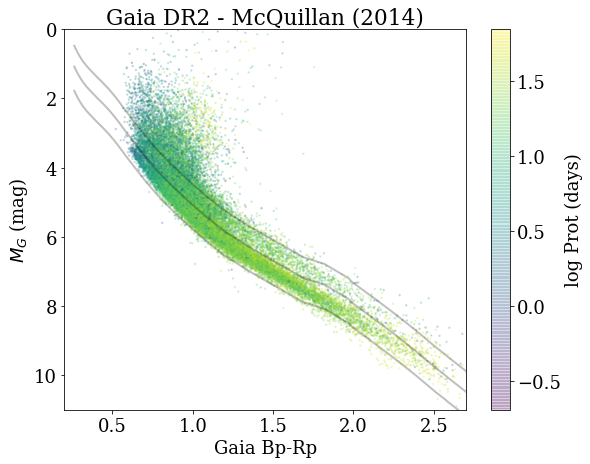

In [364]:
plt.figure(figsize=(9,7))
cm = plt.cm.get_cmap('Spectral')

plt.scatter(df[u'bp_rp'].values[ok], 
            df[u'phot_g_mean_mag'].values[ok] + 5. * np.log10(df[u'parallax'].values[ok]/1000.)  + 5, 
            c=np.log10(df[u'Prot'].values[ok]), alpha=0.2, s=2)

plt.plot(iso['G_BPmag'].values[iok] - iso['G_RPmag'].values[iok], iso['Gmag'].values[iok], c='k', lw=2, alpha=0.25)
plt.plot(iso['G_BPmag'].values[iok] - iso['G_RPmag'].values[iok], iso['Gmag'].values[iok] - 0.7, c='k', lw=2, alpha=0.25)
plt.plot(iso['G_BPmag'].values[iok] - iso['G_RPmag'].values[iok], iso['Gmag'].values[iok] - 1.3, c='k', lw=2, alpha=0.25)

plt.ylim(11,0)
plt.xlim(.2,2.7)
plt.xlabel('Gaia Bp-Rp')
plt.ylabel('$M_G$ (mag)')
plt.title('Gaia DR2 - McQuillan (2014)')
# plt.text(4000, 1, 'N=894', fontsize=12)

cb = plt.colorbar()
cb.set_label('log Prot (days)')

Now select things in a plausible main sequence region

In [365]:
Mg_iso = np.interp(df[u'bp_rp'].values[ok], iso['G_BPmag'].values[iok] - iso['G_RPmag'].values[iok], 
                   iso['Gmag'].values[iok])
delta_mag = Mg_iso - (df[u'phot_g_mean_mag'].values[ok] + 5. * np.log10(df[u'parallax'].values[ok]/1000.)  + 5)


/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


In [366]:
dok = np.isfinite(delta_mag)
delta_mag[dok]

array([0.94386028, 0.3911159 , 0.11597483, ..., 0.405312  , 2.92668916,
       0.67024287])

In [383]:
# main sequence stars
msok = np.where((delta_mag >= 0.2) & 
                (delta_mag <= 0.8))[0]

# binary main sequence stars
bsok = np.where((delta_mag >= 0.8) & 
                (delta_mag <= 1.3))[0]

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater_equal
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less_equal


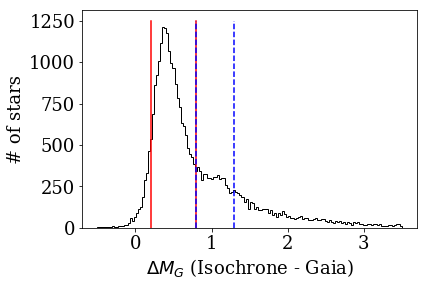

In [402]:
_ = plt.hist(delta_mag[dok], range=(-0.5,3.5), bins=150, histtype='step', lw=1, color='k')
plt.ylabel('# of stars')
plt.xlabel(r'$\Delta M_G$ (Isochrone - Gaia)')

plt.plot([0.2,0.2], [0,1250], c='r')
plt.plot([.8,.8], [0,1250], c='r')

plt.plot([0.8,0.8], [0,1250], c='b', linestyle='--')
plt.plot([1.3,1.3], [0,1250], c='b', linestyle='--')

## The Color-Rotation Diagram
This is the meat of what we're after!

The period bimodality *is* there, and most notable for the red stars again.

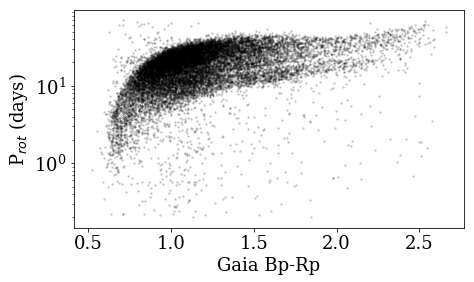

In [385]:
plt.figure(figsize=(7,4))
cm = plt.cm.get_cmap('Spectral')

plt.scatter(df[u'bp_rp'].values[ok][msok], df[u'Prot'].values[ok][msok], 
            s=5, alpha=0.25, c='k', lw=0, rasterized=True)

plt.yscale('log')
plt.xlabel('Gaia Bp-Rp')
plt.ylabel('P$_{rot}$ (days)');

Text(0,0.5,u'P$_{rot}$ (days)')

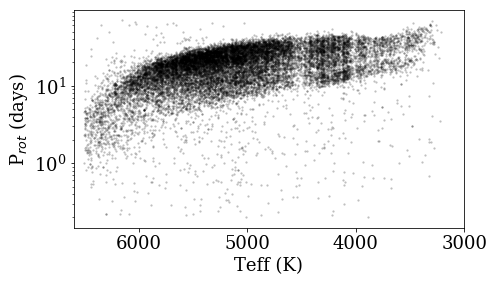

In [386]:
plt.figure(figsize=(7,4))
cm = plt.cm.get_cmap('Spectral')

plt.scatter(df[u'Teff'].values[ok][msok], df[u'Prot'].values[ok][msok], 
            s=5, alpha=0.25, c='k', lw=0, rasterized=True)

plt.yscale('log')
plt.xlabel('Teff (K)')
plt.xlim(6600,3000)
plt.ylabel('P$_{rot}$ (days)')

Text(0,0.5,u'P$_{rot}$ (days)')

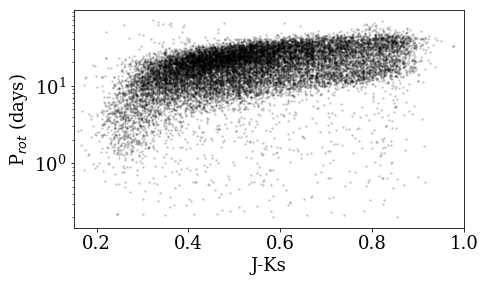

In [387]:
plt.figure(figsize=(7,4))
cm = plt.cm.get_cmap('Spectral')

plt.scatter(df[u'jmag'].values[ok][msok] - df[u'kmag'].values[ok][msok] , df[u'Prot'].values[ok][msok], 
            s=5, alpha=0.25, c='k', lw=0, rasterized=True)

plt.yscale('log')
plt.xlabel('J-Ks')
plt.xlim(0.15,1)
plt.ylabel('P$_{rot}$ (days)')

## Slices in Distance
This is *messier* than with DR1, likely because we're not just limited to the nearest 300pc!

So do what I said I'd do in the DR1 paper... make cuts in distance

Text(0,0.5,u'Number of Stars')

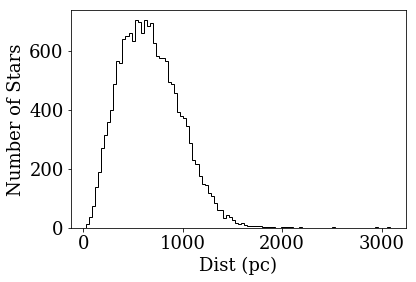

In [388]:
dist = 1000./ df[u'parallax'].values[ok][msok]

_ = plt.hist(dist, histtype='step', color='k', bins=100)
plt.xlabel('Dist (pc)')
plt.ylabel('Number of Stars')

In [389]:
dbins = np.array([0, 300, 450, 525, 600, 700, 800, 900, 1100, 3500])
print(dbins)

for k in range(len(dbins)-1):
    print(sum((dist >= dbins[k]) & (dist < dbins[k+1])))

[   0  300  450  525  600  700  800  900 1100 3500]
1746
2804
1603
1696
2251
1944
1735
2472
1562


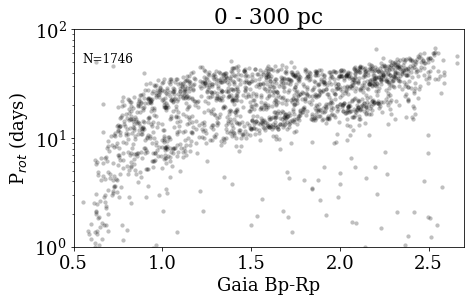

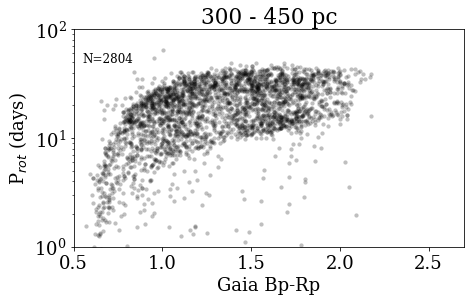

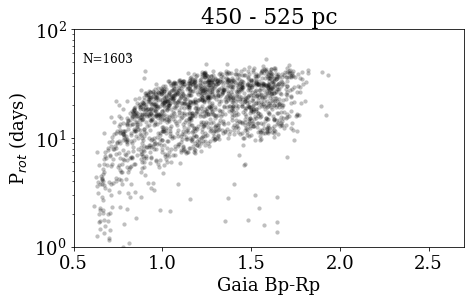

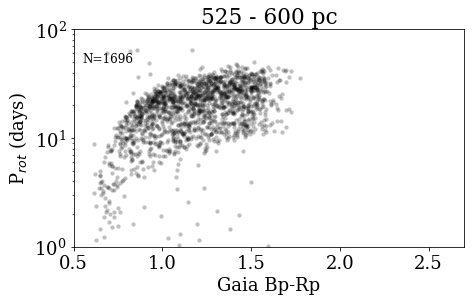

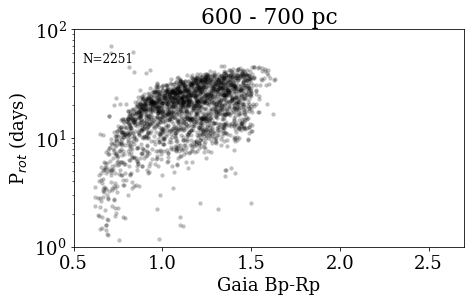

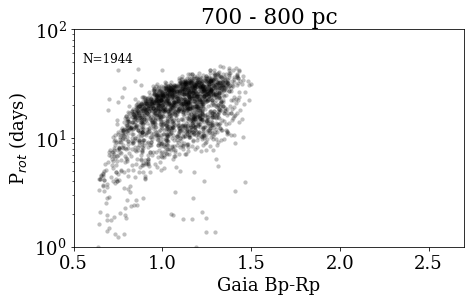

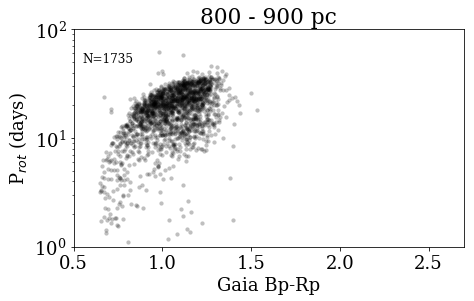

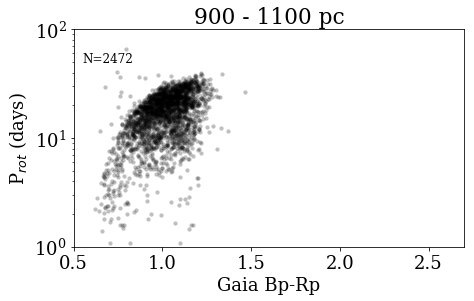

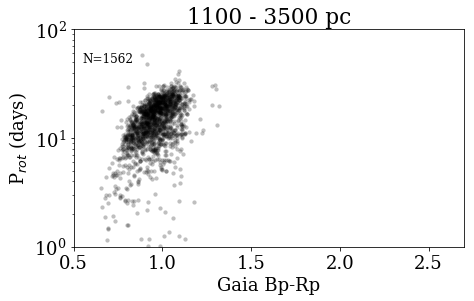

In [390]:
for k in range(len(dbins)-1):
    dd = np.where((dist >= dbins[k]) & (dist < dbins[k+1]))
    
    plt.figure(figsize=(7,4))
    plt.scatter(df[u'bp_rp'].values[ok][msok][dd], df[u'Prot'].values[ok][msok][dd], 
                s=18, alpha=0.25, c='k', lw=0, rasterized=True)
    
    plt.text(0.55,50, 'N='+str(np.size(dd)), fontsize=12)
    plt.yscale('log')
    plt.xlabel('Gaia Bp-Rp')
    plt.ylabel('P$_{rot}$ (days)');
    plt.xlim(0.5,2.7)
    plt.ylim(1,100)
    plt.title(str(dbins[k]) + ' - ' + str(dbins[k+1]) + ' pc')
    plt.show()

Text(0.5,0,u'P$_{rot}$ (days)')

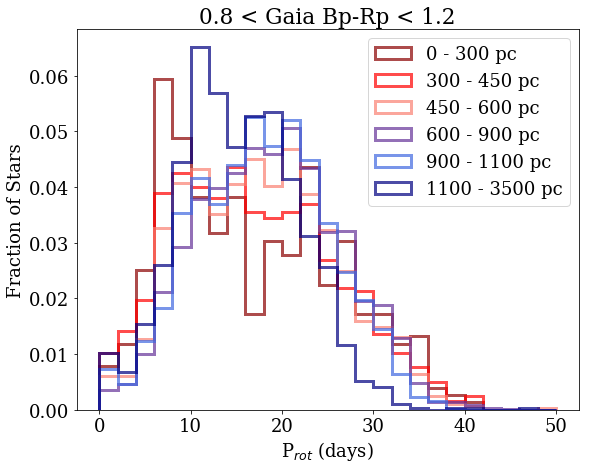

In [391]:
dbins = np.array([0, 300, 450, 600, 900, 1100, 3500])
clr = ['DarkRed', 'red', 'salmon', 'RebeccaPurple', 'RoyalBlue', 'Navy']

plt.figure(figsize=(9,7))

for k in range(0,len(dbins)-1,1):
    dd = np.where((dist >= dbins[k]) & (dist < dbins[k+1]) & 
                  (df[u'bp_rp'].values[ok][msok] >= .8) & (df[u'bp_rp'].values[ok][msok] <= 1.2))
    
    
    _ = plt.hist((df[u'Prot'].values[ok][msok][dd]), histtype='step', bins=25, range=(0,50),
                 label=str(dbins[k]) + ' - ' + str(dbins[k+1]) + ' pc', 
                 normed=True, lw=3, alpha=0.7, color=clr[k])
plt.legend()
plt.title('0.8 < Gaia Bp-Rp < 1.2')
plt.ylabel('Fraction of Stars')
plt.xlabel('P$_{rot}$ (days)')


Text(0.5,0,u'P$_{rot}$ (days)')

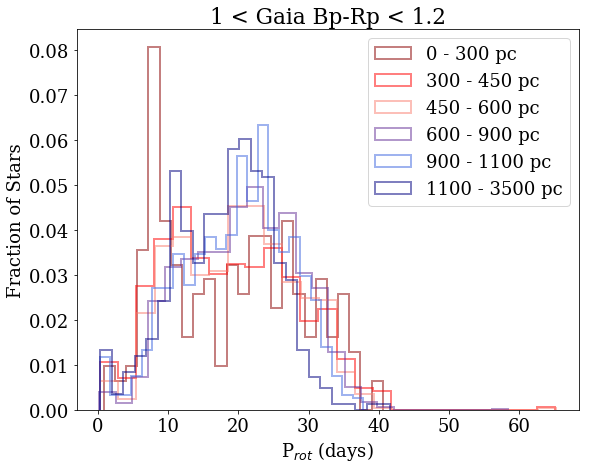

In [392]:
dbins = np.array([0, 300, 450, 600, 900, 1100, 3500])
clr = ['DarkRed', 'red', 'salmon', 'RebeccaPurple', 'RoyalBlue', 'Navy']

plt.figure(figsize=(9,7))

for k in range(0,len(dbins)-1,1):
    dd = np.where((dist >= dbins[k]) & (dist < dbins[k+1]) & 
                  (df[u'bp_rp'].values[ok][msok] >= 1) & (df[u'bp_rp'].values[ok][msok] <= 1.2))
    
    
    _ = plt.hist((df[u'Prot'].values[ok][msok][dd]), histtype='step', bins=25,
                 label=str(dbins[k]) + ' - ' + str(dbins[k+1]) + ' pc', 
                 normed=True, lw=2, alpha=0.5, color=clr[k])
plt.legend()
plt.title('1 < Gaia Bp-Rp < 1.2')
plt.ylabel('Fraction of Stars')
plt.xlabel('P$_{rot}$ (days)')



(0, 1500)

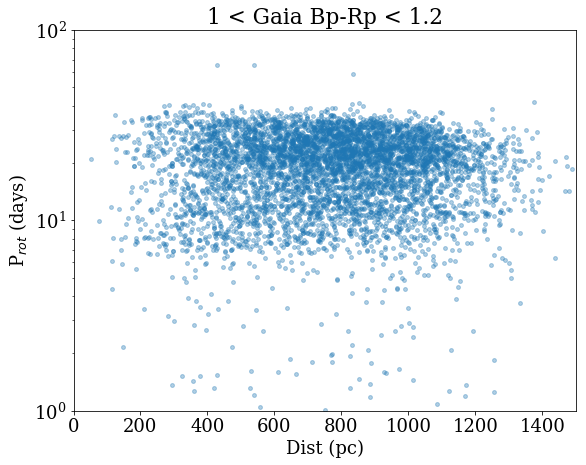

In [393]:
dd = np.where((df[u'bp_rp'].values[ok][msok] >= 1.) & (df[u'bp_rp'].values[ok][msok] <= 1.2))

plt.figure(figsize=(9,7))
plt.scatter(dist[dd], (df[u'Prot'].values[ok][msok][dd]), alpha=0.35, s=15)
plt.yscale('log')
plt.title('1 < Gaia Bp-Rp < 1.2')
plt.ylabel('P$_{rot}$ (days)')
plt.xlabel('Dist (pc)')
plt.ylim(1,100)
plt.xlim(0,1500)



(0, 800)

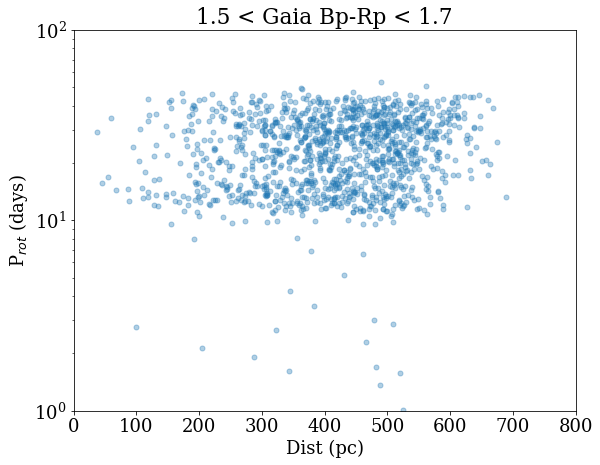

In [394]:
dd = np.where((df[u'bp_rp'].values[ok][msok] >= 1.5) & (df[u'bp_rp'].values[ok][msok] <= 1.7))

plt.figure(figsize=(9,7))
plt.scatter(dist[dd], (df[u'Prot'].values[ok][msok][dd]), alpha=0.35, s=25)
plt.yscale('log')
plt.title('1.5 < Gaia Bp-Rp < 1.7')
plt.ylabel('P$_{rot}$ (days)')
plt.xlabel('Dist (pc)')
plt.ylim(1,100)
plt.xlim(0,800)


## Singles vs Binaries

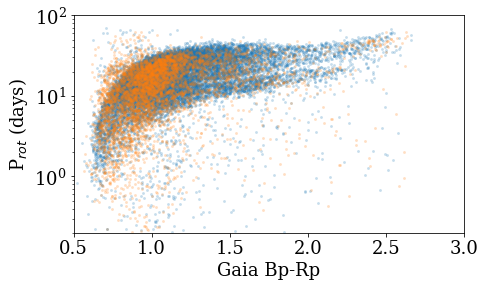

In [395]:
plt.figure(figsize=(7,4))
plt.scatter(df[u'bp_rp'].values[ok][msok], df[u'Prot'].values[ok][msok], 
            s=8, alpha=0.25, lw=0, rasterized=True)
plt.scatter(df[u'bp_rp'].values[ok][bsok], df[u'Prot'].values[ok][bsok], 
            s=8, alpha=0.25, lw=0, rasterized=True)

plt.yscale('log')
plt.xlabel('Gaia Bp-Rp')
plt.ylabel('P$_{rot}$ (days)');
plt.xlim(0.5,3)
plt.ylim(0.2,100)
plt.show()

Text(0.5,1,u'1 < Gaia Bp-Rp < 1.2')

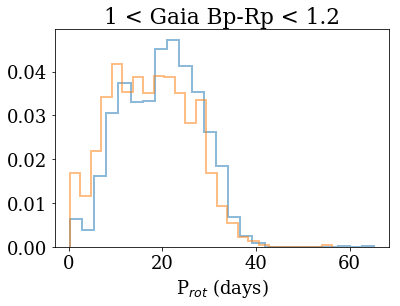

In [396]:
ms1 = np.where((df[u'bp_rp'].values[ok][msok] >= 1) & (df[u'bp_rp'].values[ok][msok] <= 1.2))
bs1 = np.where((df[u'bp_rp'].values[ok][bsok] >= 1) & (df[u'bp_rp'].values[ok][bsok] <= 1.2))

_ = plt.hist((df[u'Prot'].values[ok][msok][ms1]), histtype='step', bins=25,
             normed=True, lw=2, alpha=0.5)
_ = plt.hist((df[u'Prot'].values[ok][bsok][bs1]), histtype='step', bins=25,
             normed=True, lw=2, alpha=0.5)

plt.xlabel('P$_{rot}$ (days)');
plt.title('1 < Gaia Bp-Rp < 1.2')


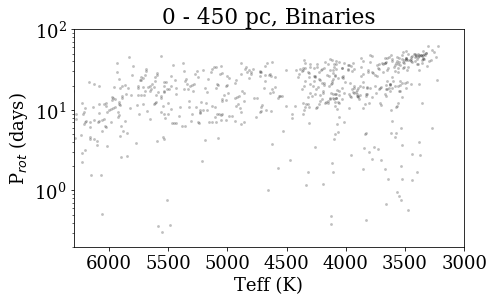

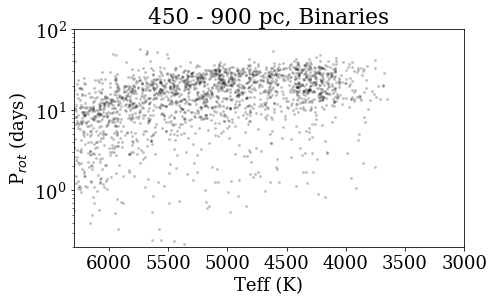

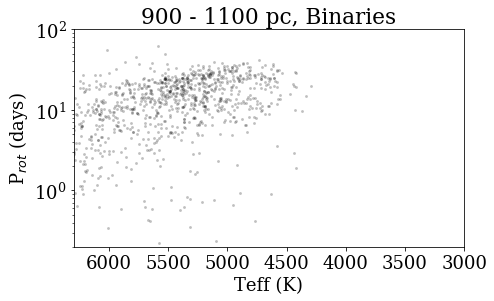

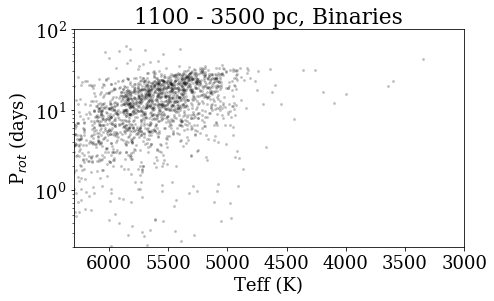

In [397]:
bdist = 1000./ df[u'parallax'].values[ok][bsok]
bbins = np.array([0, 450, 900, 1100, 3500])


for k in range(len(bbins)-1):
    dd = np.where((bdist >= bbins[k]) & (bdist < bbins[k+1]))
    
    plt.figure(figsize=(7,4))
    plt.scatter(df[u'Teff'].values[ok][bsok][dd], df[u'Prot'].values[ok][bsok][dd], 
                s=8, alpha=0.25, c='k', lw=0, rasterized=True)

    plt.yscale('log')
    plt.xlabel('Teff (K)')
    plt.ylabel('P$_{rot}$ (days)');
    plt.xlim(6300,3000)
    plt.ylim(0.2,100)
    plt.title(str(bbins[k]) + ' - ' + str(bbins[k+1]) + ' pc, Binaries')
    plt.show()

## next steps...
as of 1030am, day1

The goal is (currently) to see how far in distance the period bimodality exists. 

A seconday goal is to see if there are other period (age) structures

Since the population of stars (GKM) changes vs distance due to apparent brightnes limits of Kepler, need to consider all stars togeather. THUS, we need to estimate an AGE for each star (enter the GRYOCHRONE!) and look at the age spread vs distance.

**Problem:** No gyrochrones are defined for the Gaia bands... YET

## Something about subgiants too

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


Text(0.5,1,u'1 < Gaia Bp-Rp < 1.1')

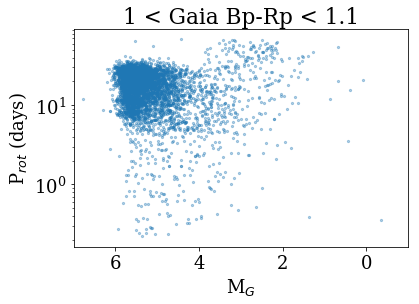

In [398]:
sg = np.where((df[u'bp_rp'].values[ok] >= 1) & (df[u'bp_rp'].values[ok] <= 1.1))

plt.scatter(df[u'phot_g_mean_mag'].values[ok][sg] + 5. * np.log10(df[u'parallax'].values[ok][sg]/1000.)  + 5, 
            df[u'Prot'].values[ok][sg], alpha=0.35, s=5)
plt.xlim(7,-1)
plt.yscale('log')
plt.xlabel('M$_G$')
plt.ylabel('P$_{rot}$ (days)');
plt.title('1 < Gaia Bp-Rp < 1.1')

